In [2]:
import torch
import torch.nn.functional as F
from torch_geometric.data import HeteroData
from torch_geometric.nn import SAGEConv, HeteroConv, Linear
import os

/accounts/masters/quannm/fraud-detection-gnn/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Training on: {device}")

Training on: cpu


In [4]:
load_path = '../data/fraud_graph_full.pt'

if os.path.exists(load_path):
    data = torch.load(load_path, weights_only=False)
    print(data)
    
    num_features = data['transaction'].x.shape[1]
    print(f"Input Features: {num_features}")
else:
    raise FileNotFoundError(f"Could not find {load_path}")

HeteroData(
  transaction={
    x=[590540, 11],
    y=[590540],
  },
  entity={ x=[10208, 11] },
  (transaction, connected_to, entity)={ edge_index=[2, 115712] },
  (entity, rev_connected_to, transaction)={ edge_index=[2, 115712] }
)
Input Features: 11


In [5]:
num_tx = data['transaction'].num_nodes
train_end = int(0.7 * num_tx)
val_end = int(0.85 * num_tx)

data['transaction'].train_mask = torch.zeros(num_tx, dtype=torch.bool)
data['transaction'].train_mask[:train_end] = True

data['transaction'].val_mask = torch.zeros(num_tx, dtype=torch.bool)
data['transaction'].val_mask[train_end:val_end] = True

data['transaction'].test_mask = torch.zeros(num_tx, dtype=torch.bool)
data['transaction'].test_mask[val_end:] = True

print(f"Train: {data['transaction'].train_mask.sum()}")
print(f"Val:   {data['transaction'].val_mask.sum()}")
print(f"Test:  {data['transaction'].test_mask.sum()}")

data = data.to(device)

Train: 413378
Val:   88581
Test:  88581


In [6]:
class HeteroGNN(torch.nn.Module):
    def __init__(self, metadata, hidden_channels, out_channels, num_layers=2):
        super().__init__()
        
        self.convs = torch.nn.ModuleList()
        
        # Layer 1: Input -> Hidden
        self.convs.append(HeteroConv({
            edge_type: SAGEConv((-1, -1), hidden_channels) 
            for edge_type in metadata[1]
        }, aggr='sum')) 

        # Layer 2: Hidden -> Hidden
        for _ in range(num_layers - 2):
            self.convs.append(HeteroConv({
                edge_type: SAGEConv((-1, -1), hidden_channels) 
                for edge_type in metadata[1]
            }, aggr='sum'))

        # Layer Output: Hidden -> Hidden
        self.convs.append(HeteroConv({
            edge_type: SAGEConv((-1, -1), hidden_channels) 
            for edge_type in metadata[1]
        }, aggr='sum'))

        # Classifier: Hidden -> Fraud/Legit
        self.lin = Linear(hidden_channels, out_channels)

    def forward(self, x_dict, edge_index_dict):
        for conv in self.convs:
            x_dict = conv(x_dict, edge_index_dict)
            x_dict = {key: x.relu() for key, x in x_dict.items()}
        
        return self.lin(x_dict['transaction'])

# Initialize
model = HeteroGNN(data.metadata(), hidden_channels=64, out_channels=2, num_layers=2)
model = model.to(device)
print(model)

HeteroGNN(
  (convs): ModuleList(
    (0-1): 2 x HeteroConv(num_relations=2)
  )
  (lin): Linear(64, 2, bias=True)
)


In [7]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

train_y = data['transaction'].y[data['transaction'].train_mask]
num_legit = (train_y == 0).sum()
num_fraud = (train_y == 1).sum()

fraud_weight = num_legit / num_fraud
class_weights = torch.tensor([1.0, fraud_weight], device=device)

print(f"Fraud Weight: {fraud_weight:.2f}")

loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)

Fraud Weight: 27.43


In [8]:
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x_dict, data.edge_index_dict)
    
    mask = data['transaction'].train_mask
    loss = loss_fn(out[mask], data['transaction'].y[mask])
    
    loss.backward()
    optimizer.step()
    return float(loss)

@torch.no_grad()
def test():
    model.eval()
    out = model(data.x_dict, data.edge_index_dict)
    pred = out.argmax(dim=1)
    
    accs = []
    for mask in [data['transaction'].train_mask, data['transaction'].val_mask, data['transaction'].test_mask]:
        correct = (pred[mask] == data['transaction'].y[mask]).sum()
        accs.append(int(correct) / int(mask.sum()))
    return accs

print("Starting Training Loop...")
for epoch in range(1, 201): 
    loss = train()
    train_acc, val_acc, test_acc = test()
    
    if epoch % 10 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')

Starting Training Loop...


/tmp/ipykernel_3080342/1296494338.py:11: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:835.)
  return float(loss)


Epoch: 010, Loss: 0.6231, Train Acc: 0.5915, Val Acc: 0.6444
Epoch: 020, Loss: 0.5898, Train Acc: 0.6499, Val Acc: 0.6938
Epoch: 030, Loss: 0.5636, Train Acc: 0.8132, Val Acc: 0.8323
Epoch: 040, Loss: 0.5438, Train Acc: 0.8167, Val Acc: 0.8332
Epoch: 050, Loss: 0.5291, Train Acc: 0.5994, Val Acc: 0.6508
Epoch: 060, Loss: 0.5207, Train Acc: 0.6714, Val Acc: 0.7140
Epoch: 070, Loss: 0.5114, Train Acc: 0.8247, Val Acc: 0.8419
Epoch: 080, Loss: 0.5208, Train Acc: 0.5380, Val Acc: 0.5995
Epoch: 090, Loss: 0.5050, Train Acc: 0.8868, Val Acc: 0.8928
Epoch: 100, Loss: 0.4962, Train Acc: 0.7202, Val Acc: 0.7557
Epoch: 110, Loss: 0.4896, Train Acc: 0.7526, Val Acc: 0.7809
Epoch: 120, Loss: 0.4841, Train Acc: 0.8328, Val Acc: 0.8478
Epoch: 130, Loss: 0.4827, Train Acc: 0.7368, Val Acc: 0.7697
Epoch: 140, Loss: 0.4871, Train Acc: 0.8606, Val Acc: 0.8713
Epoch: 150, Loss: 0.4839, Train Acc: 0.7057, Val Acc: 0.7446
Epoch: 160, Loss: 0.4883, Train Acc: 0.9066, Val Acc: 0.9084
Epoch: 170, Loss: 0.4733

Performance on TEST_MASK
              precision    recall  f1-score   support

       Legit       0.98      0.83      0.90     85498
       Fraud       0.11      0.58      0.19      3083

    accuracy                           0.82     88581
   macro avg       0.55      0.71      0.54     88581
weighted avg       0.95      0.82      0.88     88581



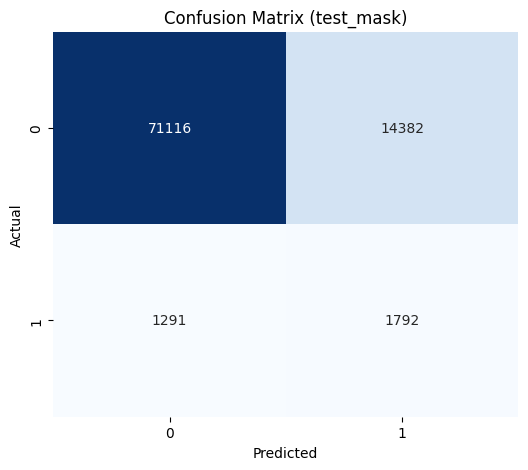

In [10]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

@torch.no_grad()
def evaluate_performance(mask_name='test_mask'):
    model.eval()
    
    # Predictions
    out = model(data.x_dict, data.edge_index_dict)
    pred = out.argmax(dim=1)
    
    # Select Test Set
    mask = data['transaction'][mask_name]
    y_true = data['transaction'].y[mask].cpu().numpy()
    y_pred = pred[mask].cpu().numpy()
    
    print(f"Performance on {mask_name.upper()}")
    print(classification_report(y_true, y_pred, target_names=['Legit', 'Fraud']))
    
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix ({mask_name})')
    plt.show()

evaluate_performance('test_mask')

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)

num_legit = (data['transaction'].y[data['transaction'].train_mask] == 0).sum()
num_fraud = (data['transaction'].y[data['transaction'].train_mask] == 1).sum()
raw_ratio = num_legit / num_fraud

softer_weight = torch.tensor([1.0, raw_ratio / 3.0], device=device)

print(f"Old Weight: {raw_ratio:.2f}")
print(f"New 'Soft' Weight: {softer_weight[1]:.2f}")

loss_fn = torch.nn.CrossEntropyLoss(weight=softer_weight)

Old Weight: 27.43
New 'Soft' Weight: 9.14


In [12]:
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x_dict, data.edge_index_dict)
    
    mask = data['transaction'].train_mask
    loss = loss_fn(out[mask], data['transaction'].y[mask])
    
    loss.backward()
    optimizer.step()
    return float(loss)

@torch.no_grad()
def test():
    model.eval()
    out = model(data.x_dict, data.edge_index_dict)
    pred = out.argmax(dim=1)
    
    accs = []
    for mask in [data['transaction'].train_mask, data['transaction'].val_mask, data['transaction'].test_mask]:
        correct = (pred[mask] == data['transaction'].y[mask]).sum()
        accs.append(int(correct) / int(mask.sum()))
    return accs

print("Starting Training Loop...")
for epoch in range(1, 201): 
    loss = train()
    train_acc, val_acc, test_acc = test()
    
    if epoch % 10 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')

Starting Training Loop...
Epoch: 010, Loss: 0.3961, Train Acc: 0.9351, Val Acc: 0.9342
Epoch: 020, Loss: 0.3851, Train Acc: 0.9483, Val Acc: 0.9448
Epoch: 030, Loss: 0.3828, Train Acc: 0.9529, Val Acc: 0.9508
Epoch: 040, Loss: 0.3812, Train Acc: 0.9521, Val Acc: 0.9496
Epoch: 050, Loss: 0.3804, Train Acc: 0.9520, Val Acc: 0.9497
Epoch: 060, Loss: 0.3799, Train Acc: 0.9516, Val Acc: 0.9494
Epoch: 070, Loss: 0.3795, Train Acc: 0.9517, Val Acc: 0.9494
Epoch: 080, Loss: 0.3791, Train Acc: 0.9518, Val Acc: 0.9495
Epoch: 090, Loss: 0.3788, Train Acc: 0.9517, Val Acc: 0.9493
Epoch: 100, Loss: 0.3785, Train Acc: 0.9517, Val Acc: 0.9493
Epoch: 110, Loss: 0.3782, Train Acc: 0.9518, Val Acc: 0.9494
Epoch: 120, Loss: 0.3779, Train Acc: 0.9519, Val Acc: 0.9495
Epoch: 130, Loss: 0.3776, Train Acc: 0.9519, Val Acc: 0.9495
Epoch: 140, Loss: 0.3773, Train Acc: 0.9519, Val Acc: 0.9496
Epoch: 150, Loss: 0.3770, Train Acc: 0.9520, Val Acc: 0.9496
Epoch: 160, Loss: 0.3768, Train Acc: 0.9520, Val Acc: 0.949

Performance on TEST_MASK
              precision    recall  f1-score   support

       Legit       0.98      0.97      0.97     85498
       Fraud       0.30      0.34      0.32      3083

    accuracy                           0.95     88581
   macro avg       0.64      0.65      0.65     88581
weighted avg       0.95      0.95      0.95     88581



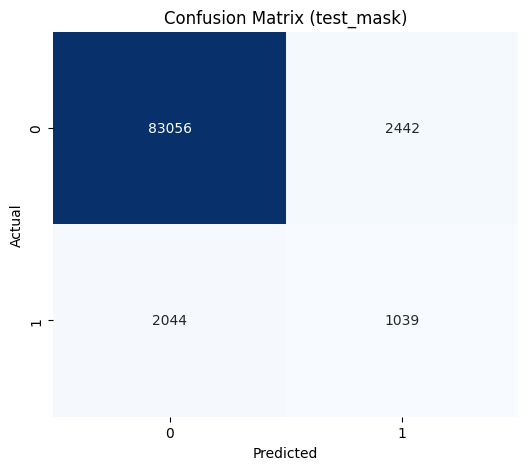

In [13]:
@torch.no_grad()
def evaluate_performance(mask_name='test_mask'):
    model.eval()
    
    # Predictions
    out = model(data.x_dict, data.edge_index_dict)
    pred = out.argmax(dim=1)
    
    # Select Test Set
    mask = data['transaction'][mask_name]
    y_true = data['transaction'].y[mask].cpu().numpy()
    y_pred = pred[mask].cpu().numpy()
    
    print(f"Performance on {mask_name.upper()}")
    print(classification_report(y_true, y_pred, target_names=['Legit', 'Fraud']))
    
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix ({mask_name})')
    plt.show()

evaluate_performance('test_mask')